In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000        # number of points

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 1

LEARNING_RATE = 1e-3
ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

# only diagonal, but we are in 1D so it does not matter anyway
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 1
def true_potential(x):
    return (x**4-4*x**2+3*x)/2


def true_drift(x):
    return -(4*x**3 - 2*4*x+3)/2 # negative derivative of the potential


def true_diffusivity(x):
    return (1e-1*x+1)*0.5
    # return true_drift(x), true_diffusivity(x)


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

xlim = [-2, 2]

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[0], high=xlim[1], n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[0], high=xlim[1],
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 1)


In [4]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler")

model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           100         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           100         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

In [5]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

training for 100 epochs with 9000 data points, validating with 1000
The average loss for epoch 99 is -0.0011795607 

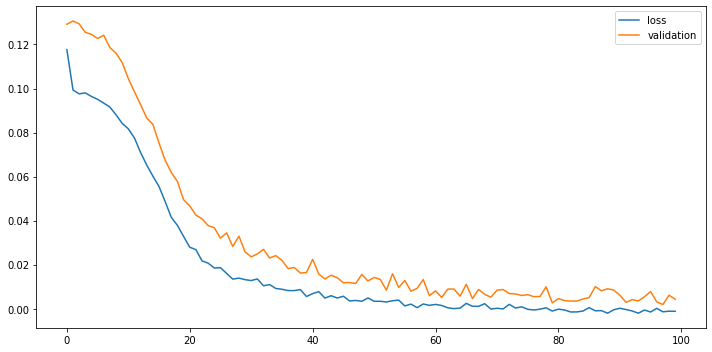

In [6]:
fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()
plt.gcf().tight_layout()

In [7]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -0.0011795607499531925
Validation loss final: 0.004302837987806972


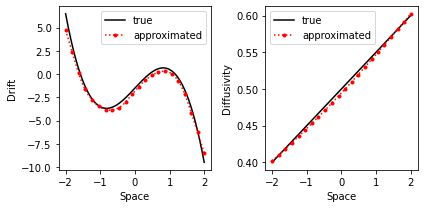

In [8]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

plt.gcf().tight_layout()
plt.gcf().savefig("figures/example_1dcubic_functions.pdf")
plt.gcf().savefig("figures/example_1dcubic_functions.png")

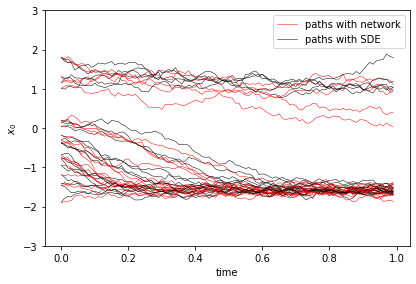

In [9]:
T_steps = 100
N_iterates = 20

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylim([-3,3])
plt.gca().set_ylabel(r"$x_0$");

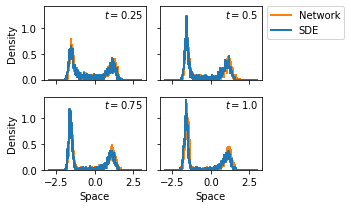

In [11]:
"""
Generate the probability density of all states at a particular time t.
"""


N_iterates = 50
n_initials = 50
t_ends = [0.25, 0.5, 0.75, 1.0]
idx_ax = 0
rng = np.random.default_rng(random_seed)
tf.random.set_seed(random_seed)

fig, ax = plt.subplots(2, 2, figsize=(5, 3), sharey=True, sharex=True)

for t_end in t_ends:
    _pn = []
    _pt = []

    for k in range(n_initials):
        initial_condition = np.array([np.linspace(xlim[0], xlim[1], n_initials)[k]]).reshape(1, 1)

        def gen_results_n(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            paths = sde_i.sample_path(initial_condition, step_size, T_steps, N_iterates)

            time_steps = [np.arange(T_steps) * step_size] * N_iterates
            return time_steps, paths


        def gen_results_t(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            return generate_results(true_drift_diffusivity,
                                step_size, initial_condition,
                                rng, T_steps = T_steps, N_iterates=N_iterates)

        t0 = time()
        pn, time_steps_n, paths_n = probability_density(t=t_end, _generate_results=gen_results_n,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        #print(f"sampling network took {time()-t0} seconds.")

        t0 = time()
        pt, time_steps_t, paths_t = probability_density(t=t_end, _generate_results=gen_results_t,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        #print(f"sampling sde took {time()-t0} seconds.")

        _pn.append(pn)
        _pt.append(pt)

    _pn = np.row_stack(_pn)
    _pt = np.row_stack(_pt)

    n1 = pd.DataFrame(_pn[:, 0], columns=["network"])
    t1 = pd.DataFrame(_pt[:, 0], columns=["true"])

    bins = np.linspace(xlim[0]-1, xlim[1]+1, 500)

    data = pd.DataFrame(np.column_stack([n1, t1]), columns=["Network", "SDE"])
    p = sns.histplot(data, ax=ax[idx_ax//2, idx_ax%2], linewidth=2, bins=bins, line_kws=dict(alpha=.3),
                 fill=False, stat="density", element="step", legend=False)

    if idx_ax==1:
        ax[idx_ax//2, idx_ax%2].legend(["Network", "SDE"], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[idx_ax//2, idx_ax%2].text(0.97, 0.9, r"$t="+str(t_end)+"$",
                                 horizontalalignment='right',
                                 verticalalignment='center',
                                 transform=ax[idx_ax//2, idx_ax%2].transAxes)
    # ax[idx_ax//2, idx_ax%2].set_xlabel(r"$x(t="+str(t_end)+")$")
    if idx_ax == 0 or idx_ax == 2:
        ax[idx_ax//2, idx_ax%2].set_ylabel("Density")
    if idx_ax == 2 or idx_ax == 3:
        ax[idx_ax//2, idx_ax%2].set_xlabel("Space")

    idx_ax += 1

fig.tight_layout()

In [12]:
fig.savefig("figures/example_1dcubic_densities.pdf")
fig.savefig("figures/example_1dcubic_densities.png")